In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import re
from jupyterthemes import jtplot
from datetime import timedelta, datetime
import calendar
import plotly.express as px
import sklearn.calibration
jtplot.style()

# Functions

## Create rolling window of jobs started or ended in hour prior to each test

In [32]:
def rollmodel_df(x, dt_col, jobs_running = False):
    y = x.rename(columns = {'DATETIME' : dt_col}).drop(columns = ['JOBID'])
    df = pd.concat([slurm_jobs, y])
    df = df.sort_values(dt_col).reset_index(drop = True)
    if jobs_running == True:
        
        begin_load_df = (df[~df['JOBID'].isnull()]
                                  [['BEGIN']]
                                  .rename(columns={'BEGIN':'TIME'})
                        )
        begin_load_df['process'] = 1
        
        end_load_df = (df[~df['JOBID'].isnull()]
                                  [['END']]
                                  .rename(columns={'END':'TIME'})
                      )
        end_load_df['process'] = -1 
        
        commands_load_df = (df[df['JOBID'].isnull()]
                                  [[dt_col]]
                                  .rename(columns={dt_col:'TIME'})
                      )
        commands_load_df['process'] = 0 
        
        load_df = begin_load_df.append(end_load_df).append(commands_load_df)
        jobs_running_prefilter = load_df.sort_values('TIME')['process'].cumsum()
        jobs_running = jobs_running_prefilter[~jobs_running_prefilter
                                                  .index
                                                  .duplicated(keep='first')]
        df['JOBSRUNNING'+dt_col] = jobs_running
    else:
        df['ROLL1HR'+dt_col] = (df
                                   .rolling('1h', on = dt_col)
                                    ['JOBID']
                                    .count()
                                )
    df = df[df['JOBID'].isnull()]
    df = df[(df[dt_col] < '2021-05-18') | (df[dt_col] >= '2021-06-01')]
    return df

## Logistic (unwraps Logit)

In [3]:
def logistic(x, a, b):
    return 1/(1+np.exp(-(a + (b*x))))

# Read in ce, filter down to testing

In [4]:
ce = pd.read_csv('../data/ce.csv')

In [5]:
ce['DATETIME'] = pd.to_datetime(ce['DATETIME'])
ce['UNRESPONSIVE'] = ce['UNRESPONSIVE'].astype('boolean')

In [6]:
ce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9547413 entries, 0 to 9547412
Data columns (total 12 columns):
 #   Column             Dtype         
---  ------             -----         
 0   DATETIME           datetime64[ns]
 1   USER               int64         
 2   RETRY              int64         
 3   TIMELAPSE          float64       
 4   RETURNCODE         int64         
 5   COMMAND            object        
 6   JOBID              float64       
 7   COMMANDTYPE        object        
 8   TESTING            bool          
 9   UNRESPONSIVE       boolean       
 10  SERVER             object        
 11  UNRESPONSIVEGROUP  float64       
dtypes: bool(1), boolean(1), datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 755.7+ MB


In [7]:
testing = ce[ce['TESTING']]

# Read in slurm_jobs

In [8]:
slurm_jobs = pd.read_csv('../data/slurm_jobs.csv')

In [9]:
datetime_cols = ['BEGIN', 'END']
for col in datetime_cols:
    slurm_jobs[col] = pd.to_datetime(slurm_jobs[col])

timedelta_cols = ['REQTIME', 'USEDTIME']
for col in timedelta_cols:
    slurm_jobs[col] = pd.to_timedelta(slurm_jobs[col])

In [10]:
slurm_jobs = slurm_jobs.drop(columns = 'ROLL1HR')

In [11]:
slurm_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395234 entries, 0 to 7395233
Data columns (total 16 columns):
 #   Column     Dtype          
---  ------     -----          
 0   JOBID      object         
 1   STATE      object         
 2   BEGIN      datetime64[ns] 
 3   END        datetime64[ns] 
 4   REQMEM     object         
 5   USEDMEM    object         
 6   REQTIME    timedelta64[ns]
 7   USEDTIME   timedelta64[ns]
 8   NODES      int64          
 9   CPUS       int64          
 10  PARTITION  object         
 11  EXITCODE   int64          
 12  TIMEOUT    bool           
 13  SIGNAL     int64          
 14  IN_ARRAY   bool           
 15  ARRAYID    float64        
dtypes: bool(2), datetime64[ns](2), float64(1), int64(4), object(5), timedelta64[ns](2)
memory usage: 804.0+ MB


## Problem 4

Finally, combine the time series information from the two datasets together to see 

(4A) how well correlated heavy job-completion load is with the unresponsiveness, and 

(4B) to see if there is some threshold of job completions per hour that generally results in unresponsiveness.

## (4A) How well correlated is heavy job-completion load with unresponsiveness?

-- Mix in logs (testing) with jobs (slurm_jobs)

   * concatenate slurm_jobs and testing; call it slurm_testing
    
-- Create rolling window to check for unresponsivenss

   * sort and reset index of slurm_testing
   * create rolling window for jobs completed in our prior to each entry; call the column ROLL1HR
   * filter slurm_testing down to TESTING == True; call it slurm_tests
   * create rolling window of jobs completed in our prior to each test
   * ensure UNRESPONSIVE is boolean
   * filter out late-May downtime; call it slurm_tests_filt
    
-- Make logistic regression model

   * Make the base model with sm.GLM
   * Make the model with ROLL1HR as exog
   * Plot the model
   * Make model with Logit to confirm results and to construct confusion matrix

### Mix in logs (testing) with jobs (slurm_jobs)

In [15]:
slurm_testing_END = rollmodel_df(testing, 'END')

### Make logistic regression model: ROLL1HR model shows AIC improvement over base model. 

### Answer: Significant result: ROLL1HR and UNRESPONSIVE are (slightly) negatively correlated.

Odds of unresponsiveness decrease by 8% with every thousand jobs ended per hour; e.g. the odds of unresponsiveness at 2000 jobs are predicted to be about 92.7% of what they are at 1000 jobs.

In [16]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_testing_END['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_END[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_testing_END['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_END['ROLL1HREND']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:                58782
Model:                            GLM   Df Residuals:                    58780
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12505.
Date:                Mon, 08 Nov 2021   Deviance:                       25011.
Time:                        10:53:14   Pearson chi2:                 5.88e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7876      0.023   -121.772      0.0

### Plot the model with regular axes

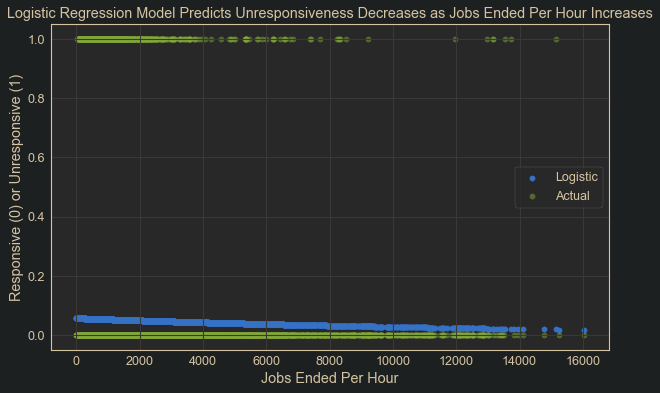

In [18]:
fig, ax = plt.subplots(figsize = (10,6))

x = slurm_testing_END['ROLL1HREND']
y_logistic = logistic(x = x, a = -2.7876, b =-7.347e-05)
plt.scatter(x, y_logistic, label = 'Logistic')

x = slurm_testing_END['ROLL1HREND']
y = slurm_testing_END['UNRESPONSIVE'].astype('int')
plt.scatter(x, y, label = 'Actual', alpha = 0.5)
#ax.axhline(0.5)
plt.legend()
plt.title("Logistic Regression Model Predicts Unresponsiveness Decreases as Jobs Ended Per Hour Increases")
plt.ylabel("Responsive (0) or Unresponsive (1)")
plt.xlabel("Jobs Ended Per Hour");

### Plot the model with log-transformed x-axis

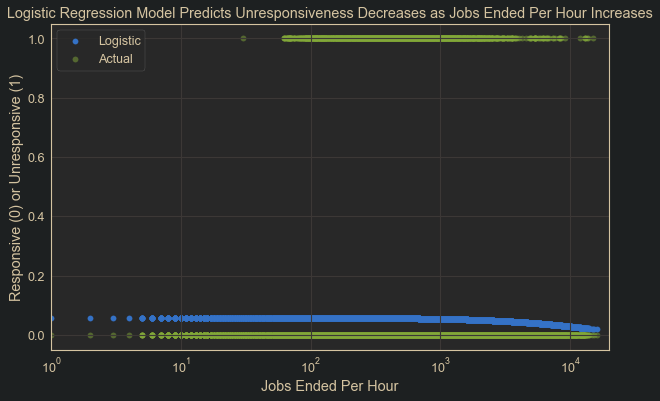

In [20]:
fig, ax = plt.subplots(figsize = (10,6))

x = slurm_testing_END['ROLL1HREND']
y_logistic = logistic(x = x, a = -2.7876, b =-7.347e-05)
plt.scatter(x, y_logistic, label = 'Logistic')

x = slurm_testing_END['ROLL1HREND']
y = slurm_testing_END['UNRESPONSIVE'].astype('int')
plt.scatter(x, y, label = 'Actual', alpha = 0.5)
ax.set(xscale = 'log', xlim = (1, 20000))
#ax.axhline(0.5)
plt.legend()
plt.title("Logistic Regression Model Predicts Unresponsiveness Decreases as Jobs Ended Per Hour Increases")
plt.ylabel("Responsive (0) or Unresponsive (1)")
plt.xlabel("Jobs Ended Per Hour");

# Build model with all commands, not just USER 9204 and COMMANDTYPE sbatch

In [21]:
slurm_allcomf = rollmodel_df(ce, 'END')

### Answer: Different coefficients but same takeaway: small negative correlation.

In [23]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_allcomf['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_allcomf[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_allcomf['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_allcomf['ROLL1HREND']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:              9406878
Model:                            GLM   Df Residuals:                  9406876
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.2030e+06
Date:                Mon, 08 Nov 2021   Deviance:                   6.4060e+06
Time:                        10:59:52   Pearson chi2:                 9.48e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9778      0.001  -1416.503      0.0

# Model with TESTING and jobs begun

In [28]:
slurm_testing_BEGIN = rollmodel_df(testing, 'BEGIN')

In [31]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_testing_BEGIN['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_BEGIN[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_testing_BEGIN['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_BEGIN['ROLL1HRBEGIN']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:                58782
Model:                            GLM   Df Residuals:                    58780
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12511.
Date:                Mon, 08 Nov 2021   Deviance:                       25023.
Time:                        11:16:21   Pearson chi2:                 5.88e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.8161      0.022   -126.153   

# Model with TESTING and jobs running

In [36]:
slurm_testing_JOBSRUNNING = rollmodel_df(testing, 'BEGIN', True)

In [37]:
slurm_testing_JOBSRUNNING.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58782 entries, 386579 to 7456480
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   JOBID              0 non-null      object         
 1   STATE              0 non-null      object         
 2   BEGIN              58782 non-null  datetime64[ns] 
 3   END                0 non-null      datetime64[ns] 
 4   REQMEM             0 non-null      object         
 5   USEDMEM            0 non-null      object         
 6   REQTIME            0 non-null      timedelta64[ns]
 7   USEDTIME           0 non-null      timedelta64[ns]
 8   NODES              0 non-null      float64        
 9   CPUS               0 non-null      float64        
 10  PARTITION          0 non-null      object         
 11  EXITCODE           0 non-null      float64        
 12  TIMEOUT            0 non-null      object         
 13  SIGNAL             0 non-null      floa

In [38]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_JOBSRUNNING[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:                58782
Model:                            GLM   Df Residuals:                    58780
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11991.
Date:                Mon, 08 Nov 2021   Deviance:                       23982.
Time:                        12:58:32   Pearson chi2:                 5.74e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.1497      0.081  

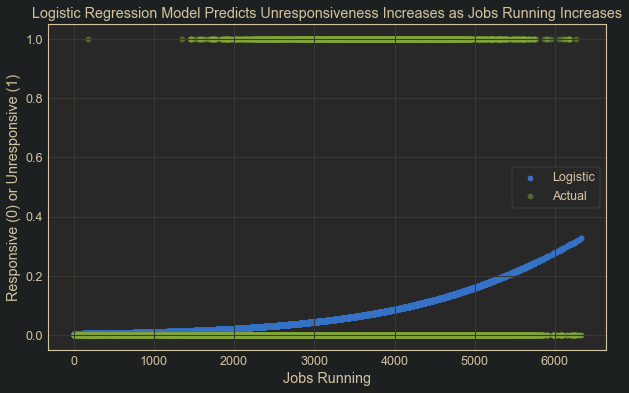

In [41]:
fig, ax = plt.subplots(figsize = (10,6))

x = slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN']
y_logistic = logistic(x = x, a = -5.1497, b =0.0007)
plt.scatter(x, y_logistic, label = 'Logistic')

x = slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN']
y = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int')
plt.scatter(x, y, label = 'Actual', alpha = 0.5)
#ax.axhline(0.5)
plt.legend()
plt.title("Logistic Regression Model Predicts Unresponsiveness Increases as Jobs Running Increases")
plt.ylabel("Responsive (0) or Unresponsive (1)")
plt.xlabel("Jobs Running");

<AxesSubplot:xlabel='Predicted Probability of Unresponsiveness', ylabel='True Probability of Unresponsiveness'>

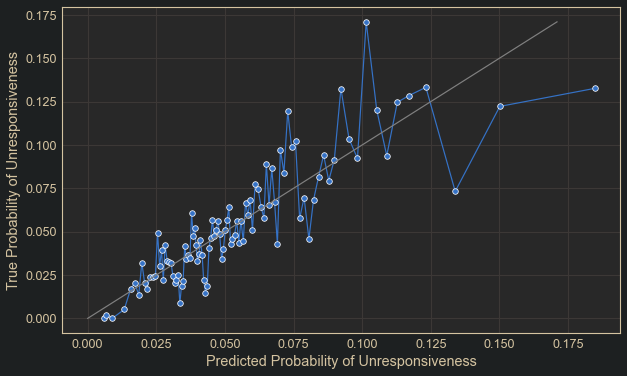

In [79]:
prob_true, prob_pred = sklearn.calibration.calibration_curve(
                                slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'), 
                                logreg_unresponsive_roll.fittedvalues,
                                strategy = 'quantile',
                                n_bins = 100
                                     )
fig, ax = plt.subplots(figsize = (10,6))
sns.lineplot(x = prob_pred, y = prob_true, ax = ax, marker = 'o')
ax.set(xlabel = 'Predicted Probability of Unresponsiveness',
       ylabel = 'True Probability of Unresponsiveness')
sns.lineplot(x = prob_true, y = prob_true, color = 'gray', )

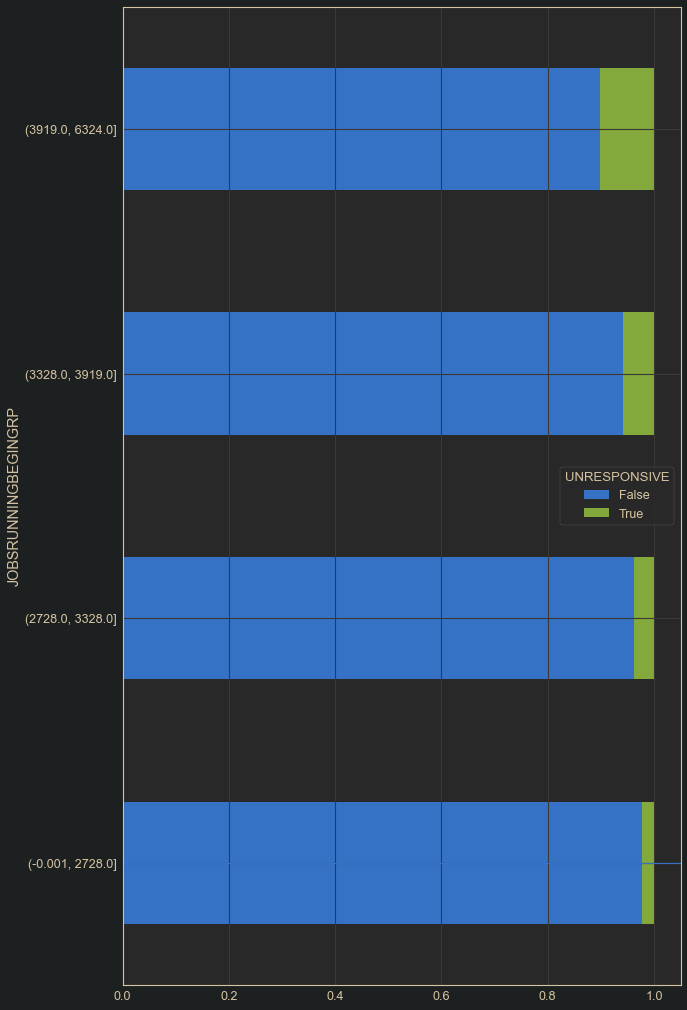

In [86]:
slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGINGRP'] = pd.qcut(slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN'], 
                                                           q = 4)

fig, ax = plt.subplots(figsize = (10,18))

(slurm_testing_JOBSRUNNING
         .groupby(['JOBSRUNNINGBEGINGRP', 'UNRESPONSIVE'])
         ['JOBSRUNNINGBEGINGRP']
         .count()/slurm_testing_JOBSRUNNING
                     .groupby('JOBSRUNNINGBEGINGRP')
                     ['JOBSRUNNINGBEGINGRP']
                     .count()
).unstack().plot(kind = 'barh', 
       stacked = True, 
       ax = ax)
ax.axhline()

In [87]:
(slurm_testing_JOBSRUNNING
         .groupby(['JOBSRUNNINGBEGINGRP', 'UNRESPONSIVE'])
         ['JOBSRUNNINGBEGINGRP']
         .count()/slurm_testing_JOBSRUNNING
                     .groupby('JOBSRUNNINGBEGINGRP')
                     ['JOBSRUNNINGBEGINGRP']
                     .count()
)

JOBSRUNNINGBEGINGRP  UNRESPONSIVE
(-0.001, 2728.0]     False           0.977095
                     True            0.022905
(2728.0, 3328.0]     False           0.961973
                     True            0.038027
(3328.0, 3919.0]     False           0.941818
                     True            0.058182
(3919.0, 6324.0]     False           0.899190
                     True            0.100810
Name: JOBSRUNNINGBEGINGRP, dtype: float64

# APPENDIX: Valley of Dry Bones

In [ ]:
# testing = testing.rename(columns = {'DATETIME' : 'END'}).drop(columns = 'JOBID')
# slurm_testing = pd.concat([slurm_jobs, testing])
# slurm_testing = slurm_testing.sort_values('END').reset_index(drop = True)
# slurm_testing['ROLL1HR'] = (slurm_testing
#                            .rolling('1h', on = 'END')
#                             ['JOBID']
#                             .count()
#                         )
# slurm_tests = slurm_testing[slurm_testing['TESTING'] == True]
# slurm_tests_filt = slurm_tests[(slurm_tests['END'] < '2021-05-18') | (slurm_tests['END'] >= '2021-06-01')]

In [ ]:
# regex = re.compile(r'((?P<hours>\d+?)h)?((?P<minutes>\d+?)m)?((?P<seconds>\d+?)s)?')

# def parse_time(time_str):
#     parts = regex.match(time_str)
#     if not parts:
#         return
#     parts = parts.groupdict()
#     time_params = {}
#     for name, param in parts.items():
#         if param:
#             time_params[name] = int(param)
#     return timedelta(**time_params)

In [ ]:
# def check_unresponsive(x, window = '1h'):
#     cef = ce.loc[(ce['DATETIME'] >= x - parse_time(window))
#                  &
#                  (ce['DATETIME'] <= x)]
#     unresp = cef['UNRESPONSIVE'].any()
#     return unresp

In [ ]:
#slurm_jobs['END'].apply(check_unresponsive)

In [ ]:
jobs_running_prefilter = load_df.sort_values('TIME')['process'].cumsum()
jobs_running = jobs_running_prefilter[~jobs_running_prefilter.index.duplicated(keep='first')]
slurm_jobs['JOBSRUNNING'] = jobs_running
slurm_jobs

In [ ]:
# George's concurrent processes code
begin_load_df = slurm_jobs[slurm_jobs['PARTITION'] == 'production'][['BEGIN']].rename(columns={'BEGIN':'TIME'})
begin_load_df['process'] = 1
end_load_df = slurm_jobs[slurm_jobs['PARTITION'] == 'production'][['END']].rename(columns={'END':'TIME'})
end_load_df['process'] = -1 
load_df = begin_load_df.append(end_load_df)
resample_interval = "D" 
fs_ts = pd.Series(list(load_df['process']), index=list(load_df['TIME']))
fs_resample = fs_ts.resample(resample_interval).sum().to_frame().cumsum()
plt.figure(figsize=(15, 10))
plt.plot(fs_resample.index, fs_resample[0])

In [ ]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_tests_filt['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_tests_filt[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_base.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))

In [ ]:
slurm_tests_filt.plot(x = 'END', y = 'ROLL1HR')

In [ ]:
fline = slurm_tests_filt.loc[slurm_tests['UNRESPONSIVE'] == False, 'ROLL1HR'].mean()
tline = slurm_tests_filt.loc[slurm_tests['UNRESPONSIVE'] == True, 'ROLL1HR'].mean()

ax = sns.stripplot(data = slurm_tests_filt, x = 'UNRESPONSIVE', y = 'ROLL1HR')
ax.axhline(fline)
ax.axhline(tline, color = '#83A83B')

In [ ]:
fline = slurm_tests_filt.loc[slurm_tests['UNRESPONSIVE'] == False, 'ROLL1HR'].mean()
tline = slurm_tests_filt.loc[slurm_tests['UNRESPONSIVE'] == True, 'ROLL1HR'].mean()

ax = sns.stripplot(data = slurm_tests_filt, x = 'UNRESPONSIVE', y = 'ROLL1HR')
ax.set(yscale = 'log')
ax.axhline(fline)
ax.axhline(tline, color = '#83A83B')

In [ ]:
slurm_tests_filt[slurm_tests_filt['UNRESPONSIVE'] == True].nsmallest(5, 'ROLL1HR')

In [ ]:
testing.info()

In [ ]:
print(testing['END'].diff().describe())
x = testing['END'].diff().apply(lambda x: x.total_seconds()).to_frame()
sns.displot(x,  
            kind = 'ecdf',
           )
plt.xlim(0.001, 1800)

In [ ]:
testing['END'].diff().nlargest(10).index

In [ ]:
testing.loc[[8218587, 8199797, 9142536, 8220651, 8194276, 8203463, 8188918,
            8381165, 8106360, 7960422]]

In [27]:
slurm_jobs

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,TIMEOUT,SIGNAL,IN_ARRAY,ARRAYID
0,24460577,COMPLETED,2020-10-01 00:05:55,2020-10-01 00:10:15,4096Mc,868.77M,0 days 12:00:00,0 days 00:04:20,1,1,production,0,False,0,False,NaN
1,24460647,COMPLETED,2020-10-01 00:10:38,2020-10-01 00:12:58,2000Mn,0.09M,2 days 00:00:00,0 days 00:02:20,1,1,sam,0,False,0,False,NaN
2,24460639,COMPLETED,2020-10-01 00:11:22,2020-10-01 00:13:31,1024Mc,221.10M,0 days 00:30:00,0 days 00:02:09,1,1,production,0,False,0,False,NaN
3,24460668,COMPLETED,2020-10-01 00:15:16,2020-10-01 00:17:23,2000Mn,0.09M,2 days 00:00:00,0 days 00:02:07,1,1,sam,0,False,0,False,NaN
4,24460671,FAILED,2020-10-01 00:17:08,2020-10-01 00:17:53,1024Mc,636.96M,0 days 00:30:00,0 days 00:00:45,1,1,production,0,False,9,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7395229,32923987,COMPLETED,2021-10-07 20:09:26,2021-10-07 20:11:21,2000Mn,0.09M,2 days 00:00:00,0 days 00:01:55,1,1,sam,0,False,0,False,NaN
7395230,32923988,COMPLETED,2021-10-07 20:15:05,2021-10-07 20:17:24,2000Mn,0.09M,2 days 00:00:00,0 days 00:02:19,1,1,sam,0,False,0,False,NaN
7395231,32923989,COMPLETED,2021-10-07 20:24:26,2021-10-07 20:26:01,2000Mn,393.07M,2 days 00:00:00,0 days 00:01:35,1,1,sam,0,False,0,False,NaN
7395232,32923996,COMPLETED,2021-10-07 20:31:08,2021-10-07 20:32:45,2000Mn,0.09M,2 days 00:00:00,0 days 00:01:37,1,1,sam,0,False,0,False,NaN
